In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
directory = "Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("train.csv")
df_test = pd.read_csv("submission.csv")

In [3]:
import sys
print(sys.executable)

c:\Users\mrmih\.conda\envs\machine_learning_env\python.exe


In [ ]:
cvNet = cv2.dnn.readNetFromCaffe('deploy.prototxt','weights.caffemodel')
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [10]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '1801.jpg',
 'NumOfAnno': 1,
 'Annotations': [{'isProtected': False,
   'ID': 924868908868875136,
   'BoundingBox': [451, 186, 895, 697],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

In [11]:
df = pd.read_csv("train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [12]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)

p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")

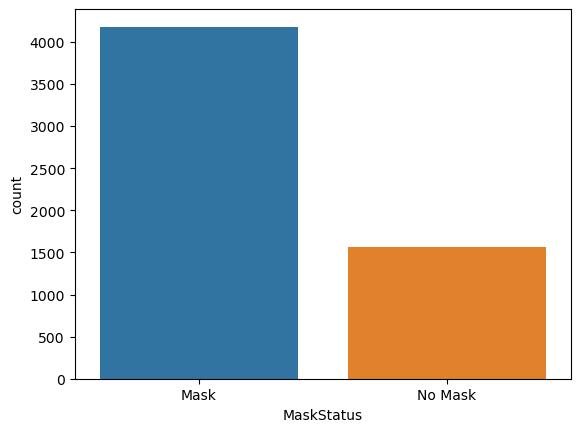

In [13]:
# Convert to pandas DataFrame
import pandas as pd
df = pd.DataFrame(p, columns=['MaskStatus'])

# Use countplot
sns.countplot(x='MaskStatus', data=df)
plt.show()

In [14]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming X and Y are already defined, where X is the image data and Y is the labels
# Example: X = np.random.rand(1000, 124, 124, 3)  # Random data for example
# Y = np.random.randint(0, 2, 1000)  # Random binary labels

# Split data into training and validation sets
xtrain, xval, ytrain, yval = train_test_split(X, Y, train_size=0.8, random_state=0)

In [9]:
# Define the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False,  
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,    
    rotation_range=15,    
    width_shift_range=0.1,
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=False
)

# Fit the datagen to the training data
datagen.fit(xtrain)

In [10]:
# Build the model
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(124, 124, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
# Train the model using the augmented data
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0] // 32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/50
143/143 [==============================] - 50s 210ms/step - loss: 0.3653 - accuracy: 0.8450 - val_loss: 0.2156 - val_accuracy: 0.9122
Epoch 2/50
143/143 [==============================] - 22s 154ms/step - loss: 0.2778 - accuracy: 0.8888 - val_loss: 0.1907 - val_accuracy: 0.9226
Epoch 3/50
143/143 [==============================] - 22s 154ms/step - loss: 0.2534 - accuracy: 0.8966 - val_loss: 0.1875 - val_accuracy: 0.9209
Epoch 4/50
143/143 [==============================] - 23s 157ms/step - loss: 0.2382 - accuracy: 0.9078 - val_loss: 0.1879 - val_accuracy: 0.9200
Epoch 5/50
143/143 [==============================] - 22s 155ms/step - loss: 0.2473 - accuracy: 0.8988 - val_loss: 0.2779 - val_accuracy: 0.8870
Epoch 6/50
143/143 [==============================] - 22s 155ms/step - loss: 0.2452 - accuracy: 0.8914 - val_loss: 0.2021 - val_accuracy: 0.9148
Epoch 7/50
143/143 [==============================] - 23s 160ms/step - loss: 0.2417 - accuracy: 0.9045 - val_loss: 0.1656 - val_ac

In [12]:
model.save(f"./models/model_{50}.h5")

In [13]:
import json

with open(f"history_params.txt","w") as file:
    file.write(json.dumps(history.params))
with open(f"history.txt","w") as file:
    file.write(json.dumps(history.history))

1/1 [==============================] - 0s 25ms/step


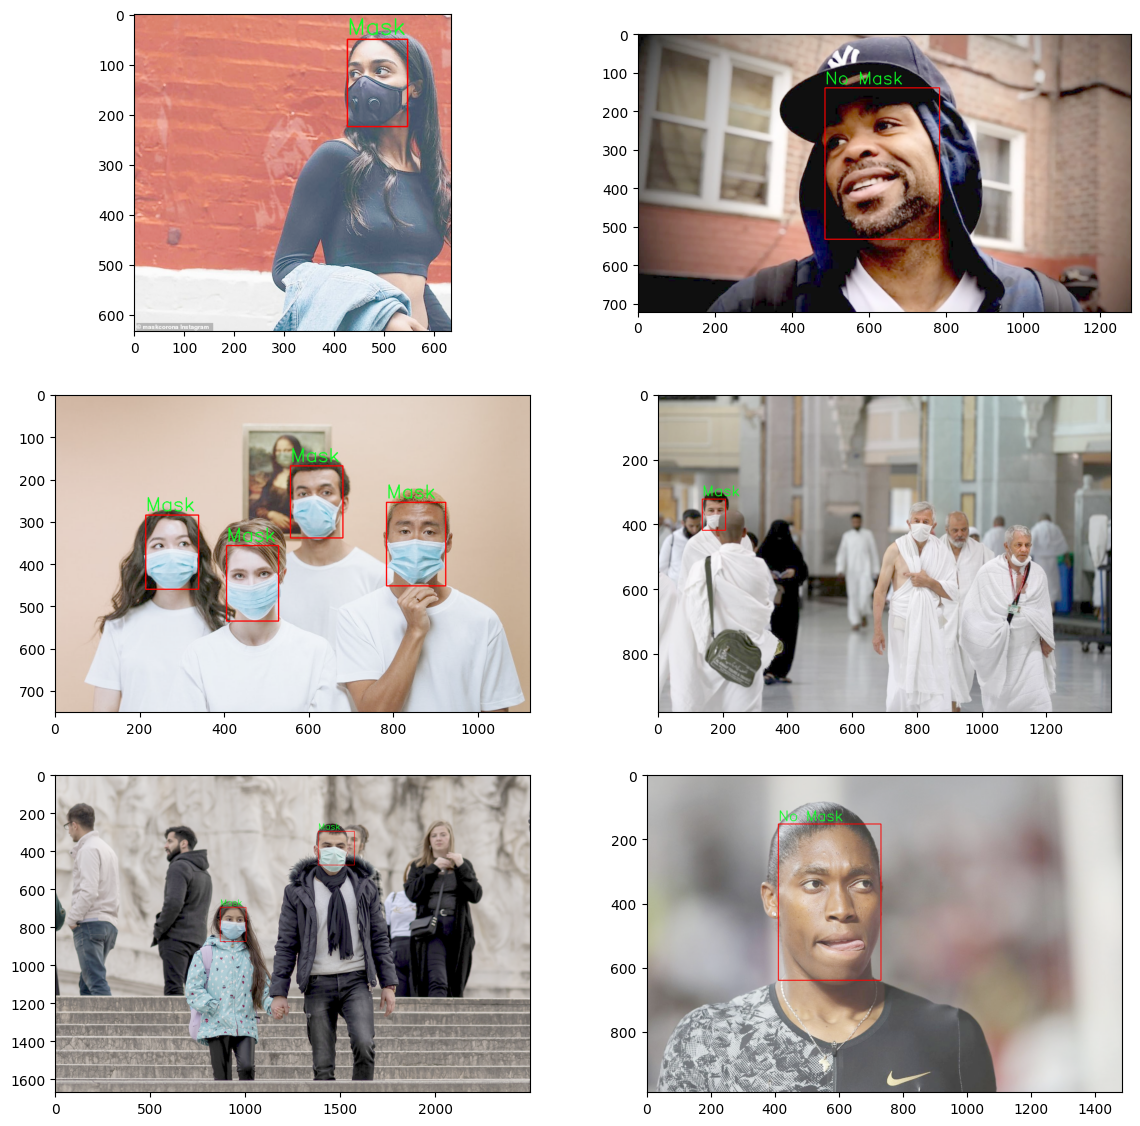

In [14]:
test_images = ['1114.png','0001.jpg', '0072.jpg','0012.jpg','0353.jpg','6098.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()